In [1]:
!pip install scikit-learn

In [113]:
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import math
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, mean_squared_error
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForMaskedLM
import random
from sklearn.preprocessing import OneHotEncoder as Encoder
from sklearn.metrics import f1_score, mean_squared_error, r2_score

In [114]:
SEQ_LEN = 271
BATCH_SIZE = 64
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 32
WEIGHT_MSE = 0.5 # DIFFERENT LOSS
PATIENCE = 3
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 0.2
CNN_OUTPUTS = 4 # Zwiększenie wpływu na wartość ciagłą
TRANSFORMER_OUTPUTS = 32

In [3]:
!wget https://raw.githubusercontent.com/kugi8412/DL-Life-Science/refs/heads/main/train_data.tsv -O train_data.tsv

df = pd.read_csv('train_data.tsv', sep='\t')
df.head()

--2025-04-14 23:40:00--  https://raw.githubusercontent.com/kugi8412/DL-Life-Science/refs/heads/main/train_data.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13382819 (13M) [text/plain]
Saving to: ‘train_data.tsv’

train_data.tsv      100%[===================>]  12.76M  --.-KB/s    in 0.09s   

2025-04-14 23:40:01 (136 MB/s) - ‘train_data.tsv’ saved [13382819/13382819]



,insert_chrom,insert_name,sequence,rna_dna_ratio,is_active
0,chr16,chr16:22572551-22572821,GTTCTCTATGCCATCTCACATTTATCCCCAAAGCCCAGGGAGGCTG...,1.179811,1
1,chr18,chr18:46761035-46761305,CAAAACATGGAGGTCTGAAGTCCCTTTTGTTCCTATCAGTATGGAG...,1.406439,1
2,chr1,chr1:209485218-209485488,TGTGGGAACAAGGAAGGAGTTAAGTTGGCATAAGCAGTTTAATAAG...,1.021255,0
3,chr3,chr3:45119427-45119697,TGCCCTATCTTGGATTCTGATTATGAGTCTCCGGGCAGCTGATGGC...,0.817915,0
4,chr14,chr14:51481635-51481905,GGTTTCCTTCGATCACCCAAGCTGGCTATTATTATCGTTCTTACAC...,0.756986,0


In [19]:
val_chroms = ['chr10', 'chr11']
train_df = df[~df['insert_chrom'].isin(val_chroms)]
val_df = df[df['insert_chrom'].isin(val_chroms)]

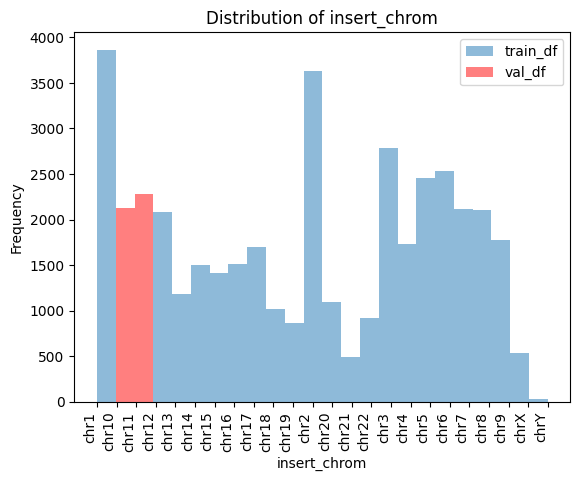

In [ ]:
chrom_to_label = {chrom: i for i, chrom in enumerate(np.unique(np.concatenate([train_df['insert_chrom'], val_df['insert_chrom']])))}

train_df.loc[:, 'insert_chrom_label'] = train_df['insert_chrom'].map(chrom_to_label)
val_df.loc[:, 'insert_chrom_label'] = val_df['insert_chrom'].map(chrom_to_label)
bins = np.histogram_bin_edges(np.concatenate([train_df['insert_chrom_label'], val_df['insert_chrom_label']]), bins=24)

plt.hist(train_df['insert_chrom_label'], bins=bins, alpha=0.5, label='train_df')
plt.hist(val_df['insert_chrom_label'], bins=bins, alpha=0.5, color='red', label='val_df')
plt.xlabel('insert_chrom')
plt.ylabel('Frequency')
plt.title('Distribution of insert_chrom')
plt.xticks(ticks=range(len(chrom_to_label)), labels=chrom_to_label.keys(), rotation=90, ha='right')
plt.legend(loc='upper right')
plt.show()

<Axes: >

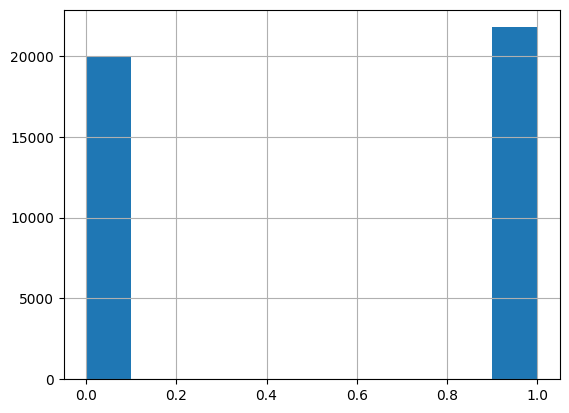

In [ ]:
# Dataset are balnced
df['is_active'].hist()

<Axes: >

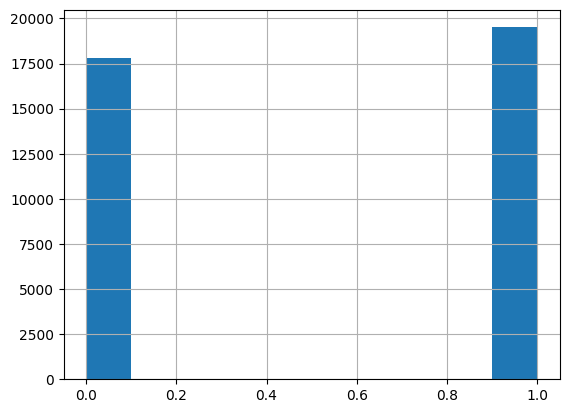

In [ ]:
train_df['is_active'].hist()

<Axes: >

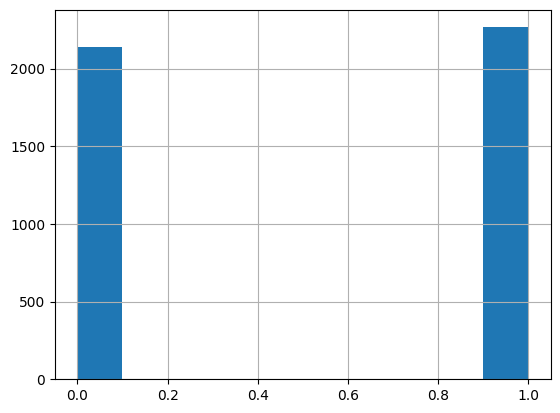

In [ ]:
val_df['is_active'].hist()

<Axes: >

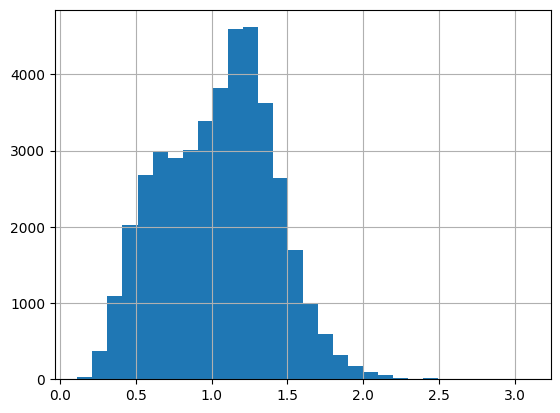

In [ ]:
# Histogram of continous values
df['rna_dna_ratio'].hist(bins=30)

<Axes: >

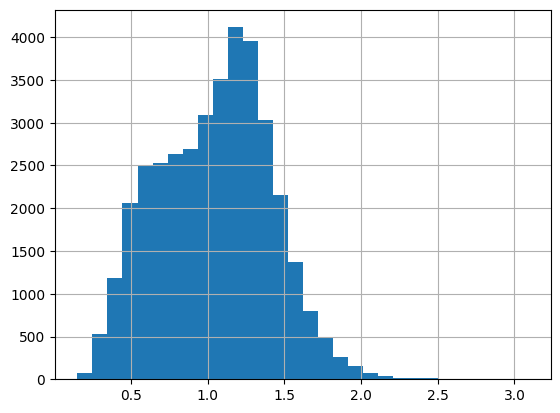

In [ ]:
train_df['rna_dna_ratio'].hist(bins=30)

<Axes: >

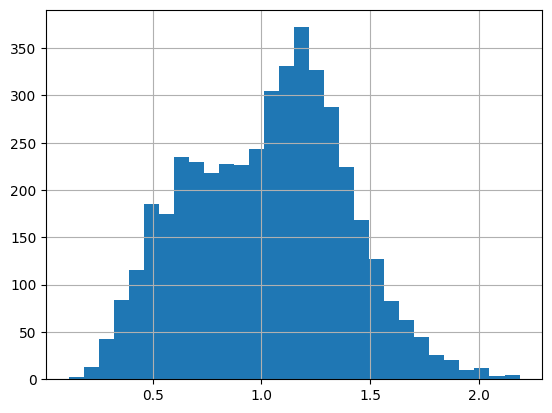

In [ ]:
val_df['rna_dna_ratio'].hist(bins=30)

In [5]:
# Sanity check of sequence length
df['sequence_length'] = df['sequence'].apply(len)
print(df['sequence_length'].unique())

[271]


In [115]:
class OHEncoder:
    def __init__(self, categories=np.array(['A', 'C', 'G', 'T'])):
        self.encoder = Encoder(sparse_output=False, categories=[categories])
        self.dictionary = categories
        self.encoder.fit(categories.reshape(-1, 1))

    def __call__(self, seq, info=False):
        seq = list(seq)
        # Jeśli w sekwencji występuje znak 'N', zamieniamy go na losowy symbol
        if 'N' in seq:
            pos = [i for i, el in enumerate(seq) if el == 'N']
            for p in pos:
                seq[p] = random.choice(self.dictionary)
        s = np.array(seq).reshape(-1, 1)
        encoded = self.encoder.transform(s).T  # wynik: macierz (4, seq_len)

        return torch.tensor(encoded).unsqueeze(0).unsqueeze(0).float()

In [116]:
# CNN (LOCAL APPROACH)
class CustomCNNEncoder(nn.Module):
    def __init__(self, seq_len=SEQ_LEN, num_channels=[128, 64, 64], kernel_widths=[9, 5, 3],
                 pooling_widths=[2, 3, 3], num_units=[271, CNN_OUTPUTS], dropout=0.5):
        """
        Przetwarza 2D one-hot zakodowaną sekwencję.
        Wynik (wektor cech) ma wymiar num_units[-1] = CNN_OUTPUTS.
        """
        super(CustomCNNEncoder, self).__init__()
        paddings = [int((w - 1) / 2) for w in kernel_widths]
        self.seq_len = seq_len

        conv_modules = []
        # Input: jeden kanał (tensor o kształcie 1 x (4, seq_len))
        num_channels_in = [1] + num_channels
        for num, (in_chan, out_chan, kernel, padding, pool) in \
                enumerate(zip(num_channels_in[:-1], num_channels_in[1:], kernel_widths, paddings, pooling_widths)):
            k = 4 if num == 0 else 1
            conv_modules += [
                nn.Conv2d(in_chan, out_chan, kernel_size=(k, kernel), padding=(0, padding)),
                nn.BatchNorm2d(out_chan),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(1, pool), ceil_mode=True)
            ]
            seq_len = math.ceil(seq_len / pool)
        self.conv_layers = nn.Sequential(*conv_modules)
        self.conv_out_size = 1 * seq_len * num_channels_in[-1]

        # Feature Extractor
        fc_layers = []
        num_units_fc = [self.conv_out_size] + num_units
        for in_units, out_units in zip(num_units_fc[:-1], num_units_fc[1:]):
            fc_layers += [nn.Linear(in_units, out_units), nn.ReLU(), nn.Dropout(p=dropout)]
        self.fc_shared = nn.Sequential(*fc_layers)

    def forward(self, x):
        x = self.conv_layers(x) # shape (B, 1, 4, seq_len)
        x = x.view(x.size(0), -1)
        feat = self.fc_shared(x)
        return feat  # tensor (B, num_units[-1])

In [117]:
class NucleotideEmbedding(nn.Module):
    def __init__(self, model_name='InstaDeepAI/nucleotide-transformer-v2-100m-multi-species'):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForMaskedLM.from_pretrained(model_name)
        self.hidden_size = self.model.config.hidden_size

        # Freeze weights
        for param in self.model.parameters():
            param.requires_grad = False

    def forward(self, seq_list):
        # seq_list: List[str]
        tokens = self.tokenizer(seq_list, return_tensors='pt', padding=True, truncation=True)
        tokens = {k: v.to(DEVICE) for k, v in tokens.items()}
        with torch.no_grad():
            outputs = self.model(**tokens)
        if outputs.hidden_states is not None:
            embeddings = outputs.hidden_states[-1].mean(dim=1)
        else:
            embeddings = torch.zeros(len(seq_list), self.hidden_size, device=DEVICE)
        return embeddings

In [118]:
class CombinedModel(nn.Module):
    def __init__(self, seq_len: int = SEQ_LEN):
        """
        Łączy:
         - cechy uzyskane z Nucleotide Transformer (transfer learning, zamrożone wagi)
         - cechy z CNN (one-hot encoding)
        Następnie cechy są scalane i przekazywane do dwóch głowic:
         - classifier (predykcja binarna – is_active)
         - regressor (predykcja ciągła – rna_dna_ratio)
        """
        super(CombinedModel, self).__init__()
        self.nt_transformer = NucleotideEmbedding()
        # ADAPTER - TRAINING LAYER (GLOBAL APPROACH)
        self.adapter = nn.Sequential(
            nn.Linear(self.nt_transformer.hidden_size, TRANSFORMER_OUTPUTS),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.cnn_encoder = CustomCNNEncoder(seq_len=seq_len)  # ekstrakcja cech z one-hot

        # Scalamy adapter (TRANSFORMER_OUTPUTS) i cechy CNN (CNN_OUTPUTS)
        fused_dim = TRANSFORMER_OUTPUTS + CNN_OUTPUTS
        self.classifier = nn.Linear(CNN_OUTPUTS, 1)
        self.regressor = nn.Linear(fused_dim, 1)

    def forward(self, raw_seq_list, oh_tensor):
        nt_features = self.nt_transformer(raw_seq_list) # shape: (B, hidden_size)
        nt_features_adapted = self.adapter(nt_features) # shape: (B, CNN_OUTPUTS + TRANSFORMER_OUTPUTS)
        cnn_features = self.cnn_encoder(oh_tensor) # shape: (B, CNN_OUTPUTS)
        fused = torch.cat([nt_features_adapted, cnn_features], dim=1)
        # CLS w fused daje słabe wyniki fused daje słabe wyniki
        out_cls = self.classifier(cnn_features)
        out_reg = self.regressor(fused)
        return out_cls, out_reg


In [119]:
class SequenceDataset(Dataset):
    def __init__(self, df, oh_encoder):
        """
        DataFrame df musi zawierać kolumny: sequence, rna_dna_ratio, is_active.
        """
        self.df = df.reset_index(drop=True)
        self.oh_encoder = oh_encoder

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        seq = row['sequence']
        oh = self.oh_encoder(seq)  # tensor o kształcie (1, 1, 4, seq_len)
        if oh is None:
            return None
        label_cls = float(row['is_active'])
        label_reg = float(row['rna_dna_ratio'])
        return seq, oh, torch.tensor(label_cls, dtype=torch.float32), torch.tensor(label_reg, dtype=torch.float32)


In [120]:
def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None
    raw_seqs, oh_list, y_cls, y_reg = zip(*batch)
    oh_tensor = torch.cat(oh_list, dim=0)  # kształt: (B, 1, 4, seq_len)
    y_cls = torch.stack(y_cls)
    y_reg = torch.stack(y_reg)
    return list(raw_seqs), oh_tensor, y_cls, y_reg

In [121]:
oh_encoder = OHEncoder()
train_dataset = SequenceDataset(train_df, oh_encoder)
val_dataset = SequenceDataset(val_df, oh_encoder)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [122]:
model = CombinedModel(seq_len=271).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
best_model = copy.deepcopy(model)
criterion_cls = nn.BCELoss()
criterion_reg = nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=PATIENCE)


best_val_loss = float('inf')
trigger_times = 0
train_losses = []
val_losses = []

The repository for InstaDeepAI/nucleotide-transformer-v2-100m-multi-species contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/InstaDeepAI/nucleotide-transformer-v2-100m-multi-species.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [112]:
for epoch in range(EPOCHS):
    model.train()
    epoch_train_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for batch in pbar:
        if batch is None:
            continue
        raw_seqs, oh_tensor, y_cls, y_reg = batch
        oh_tensor, y_cls, y_reg = oh_tensor.to(DEVICE), y_cls.to(DEVICE), y_reg.to(DEVICE)

        optimizer.zero_grad()
        out_cls, out_reg = model(raw_seqs, oh_tensor)
        out_cls = out_cls.squeeze()
        out_reg = out_reg.squeeze()
        loss_cls = criterion_cls(out_cls, y_cls)
        loss_reg = criterion_reg(out_reg, y_reg)
        # Średnia ważona, co wazniejsze, jest problem z rozpoznawanie przez CNN
        # klasyfikację binarną, ale oglnie może się przydać
        loss = loss_cls + WEIGHT_MSE * loss_reg
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Walidacja
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            if batch is None:
                continue
            raw_seqs, oh_tensor, y_cls, y_reg = batch
            oh_tensor, y_cls, y_reg = oh_tensor.to(DEVICE), y_cls.to(DEVICE), y_reg.to(DEVICE)
            out_cls, out_reg = model(raw_seqs, oh_tensor)
            out_cls = out_cls.squeeze()
            out_reg = out_reg.squeeze()
            val_loss_cls = criterion_cls(out_cls, y_cls)
            val_loss_reg = criterion_reg(out_reg, y_reg)
            loss_val = val_loss_cls + WEIGHT_MSE * val_loss_reg
            epoch_val_loss += loss_val.item()
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    scheduler.step(avg_val_loss)
    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model = copy.deepcopy(model)
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= PATIENCE:
            print("Early stopping triggered!")
            break

Epoch 1:   0%|          | 0/584 [00:00<?, ?it/s]

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


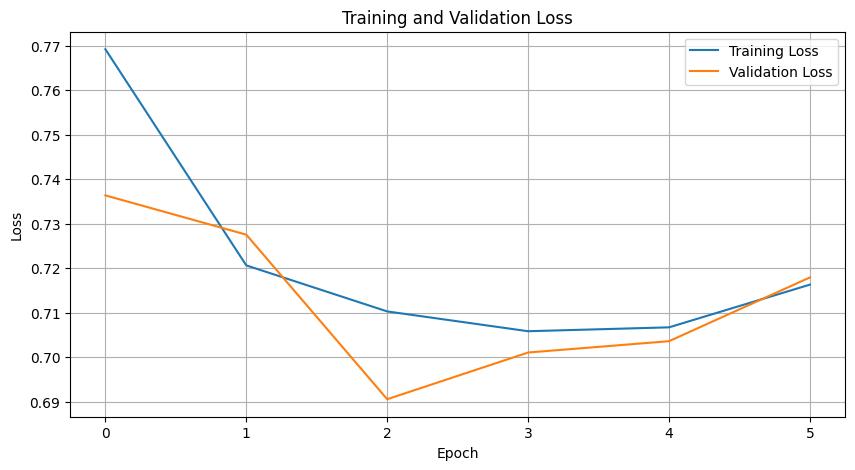

In [57]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [58]:
def evaluate(model, loader):
    model.eval()
    y_true_cls, y_pred_cls = [], []
    y_true_reg, y_pred_reg = [], []

    with torch.no_grad():
        for batch in loader:
            if batch is None:
                continue
            raw_seqs, oh_tensor, y_cls, y_reg = batch
            oh_tensor, y_cls, y_reg = oh_tensor.to(DEVICE), y_cls.to(DEVICE), y_reg.to(DEVICE)
            preds_cls, preds_reg = model(raw_seqs, oh_tensor)

            # F1 score
            preds_cls = (preds_cls.squeeze().cpu().numpy() > 0.5).astype(int)
            y_pred_cls.extend(preds_cls.tolist())
            y_true_cls.extend(y_cls.cpu().numpy().tolist())

            # Mean Square Error (MSE)
            y_pred_reg.extend(preds_reg.squeeze().cpu().numpy().tolist())
            y_true_reg.extend(y_reg.cpu().numpy().tolist())

    f1 = f1_score(y_true_cls, y_pred_cls)
    # mse = mean_squared_error(y_true_reg, y_pred_reg)
    r2 = r2_score(y_true_reg, y_pred_reg)

    return f1, r2

val_f1, val_r2 = evaluate(best_model, val_loader)
print(f"Validation F1 Score: {val_f1:.3f}")
print(f"Validation R2: {val_r2:.3f}")

Validation F1 Score: 0.678
Validation R2: 0.180


In [59]:
torch.save(best_model.state_dict(), "/content/best_model.model")

# BEST MODEL ==> Chcemy F1 > 0.9 & R2 > 0.9
# Validation F1 Score: 0.702
# Validation R2: 0.210
